# Causal Lasso

This notebook provides a quick code demo for "A Bregman Method for Structure Learning on Sparse Directed Acyclic Graphs"

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from graph_tools.data_gen import gen_graph, sample_lin_scms
from causal_lasso.solver import CLSolver
from graph_tools.metrics import compare_graphs

### Synthetic graph generation 

We generate a synthetic graph $G$ (here a Scale-Free graph with 50 nodes). 

In [3]:
graph_type = "scale-free" # choose between "scale-free" and "erdos-renyi"
n = 50 # number of nodes
G, adj_matrix = gen_graph(graph_type, n, mean_deg=8)

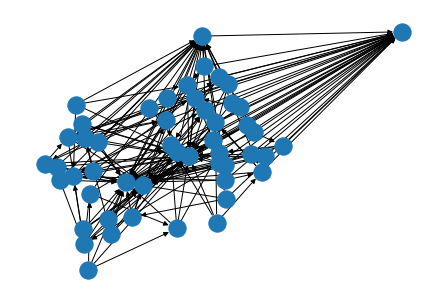

In [4]:
nx.draw(G)

### Synthetic data generation

We sample a weighted adjacency matrix `w_opt` and $m=1000$ i.i.d. samples distributed according to the SCM:

$$X = XW^* + E$$

where $X\in\mathbb{R}^{m\times n}$ is the sample matrix, $W^*\in\mathbb{R}^{n\times n}$ is the adjacency matrix of graph $G$ and $E \sim^{\text{i.i.d.}} \exp(1)$ (resp. $\mathcal{N}(0, 1)$ or $\mathrm{Gumbel}(0, 1)$

In [5]:
noise_type = "gaussian" # or "gumbel" or "exp"
X, w_opt, _ = sample_lin_scms(graph_type, noise_type, adj_matrix, nb_samples=1000, weighted=True)

## Learning

In [6]:
assert np.sum(np.abs(w_opt)) > n/(n-2)/0.3*n

In [7]:
np.save("Test", X)

We now use our algorithm to recover the weighted adjacency matrix from $X$.

In [22]:
alg = CLSolver(version="gen", dagness_exp=0.3/n, dagness_pen=1e-1, l1_pen=1e-8, eps=1e-7, max_iter=100,
                logging=True, mosek=True)
%time Wk = alg.fit(X)

assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration map may not be stable
assertion false because of thresholding: iteration 

In [23]:
compare_graphs(adj_matrix, np.abs(Wk)>=0.5)

Number of edges in ground truth graph 190.0
Number of edges in estimation 149
Correct edges 149.0
Reversed edges 0.0
Missing edges 41.0
Extra edges 0.0
SHD 41.0


(149.0, 0.0, 0.0, 41.0, 41.0)

#### NOTEARS

To run NOTEARS, download the repository from https://github.com/xunzheng/notears in the same folder as this notebook. 

In [16]:
# Importing no tears if in parent folder
try:
    import os,sys,inspect
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0,parentdir) 

    from notears.notears.linear import notears_linear
    run_notears = True
except ImportError:
    run_notears = False

In [17]:
if run_notears:
    W_notears = notears_linear(X, 1e-5, "l2")
    compare_graphs(adj_matrix, np.abs(W_notears)>=0.5)



Number of edges in ground truth graph 190.0
Number of edges in estimation 201
Correct edges 175.0
Reversed edges 0.0
Missing edges 15.0
Extra edges 26.0
SHD 41.0


## Extra visualisations

We provide extra visualisations that could be of interest to the reader. The first one shows convergence of different part of the objective with iteration of our algorithm. 

In [24]:
logging = alg.log_dict

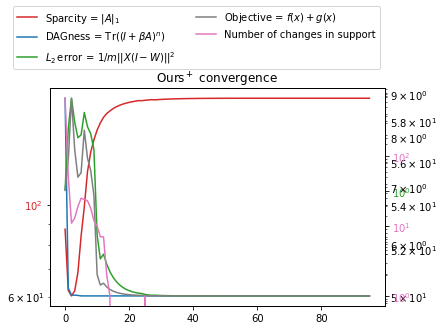

In [25]:
values_l2error = logging["l2_error"]
values_l1pen = logging["l1_val"] 
values_dagness = logging["dag_constraint"]
values_obj = values_l2error + logging["dagness_pen"] * values_dagness + logging["l1_pen"] * values_l1pen
logging["obj"] = values_obj
values_change_support = logging["nb_change_support"]

fig, ax1 = plt.subplots()

color = 'tab:red'
l1 = ax1.plot(values_l1pen, label = "Sparcity = $\|A\|_1$", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
l2 = ax2.plot(values_dagness, label="DAGness = $\mathrm{Tr}((I+\\beta A)^n)$", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
l3 = ax3.plot(values_l2error, color=color, label='$L_2\mathrm{\,error\,=\,}1/m||X (I-W)||^2$')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")

ax4 = ax1.twinx()
color = 'tab:grey'
l4 = ax4.plot(values_obj, color=color, label='Objective = $f(x)+g(x)$')
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_yscale("log")

ax5 = ax1.twinx()
color = 'tab:pink'
l5 = ax5.plot(values_change_support, color=color, label='Number of changes in support')
ax5.tick_params(axis='y', labelcolor=color)
ax5.set_yscale("log")

lines = l1 + l2 + l3 + l4 + l5
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, ncol=2,  bbox_to_anchor=(1, 1.4))
plt.title("$\mathrm{Ours}^+$ convergence");

The second one is a mere visualisation of the output as a heatmap.

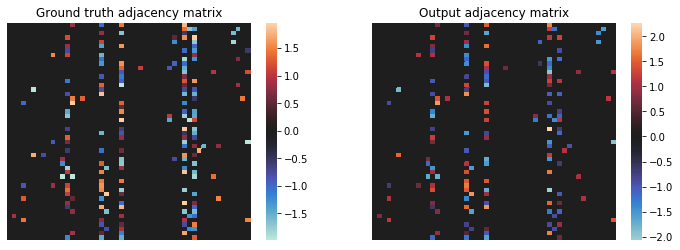

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(w_opt, center=0, ax=axs[0]); axs[0].set_xticks([]);  axs[0].set_yticks([]); 
axs[0].set_title("Ground truth adjacency matrix");
sns.heatmap(Wk, center=0, ax=axs[1]); axs[1].set_xticks([]);  axs[1].set_yticks([]); 
axs[1].set_title("Output adjacency matrix");

The last one demonstrates the convergence of the matrix support with iterations, as we go down, our algorithm progresses towards the correct graph, the last line (light blue) being the ground truth adjacency matrix

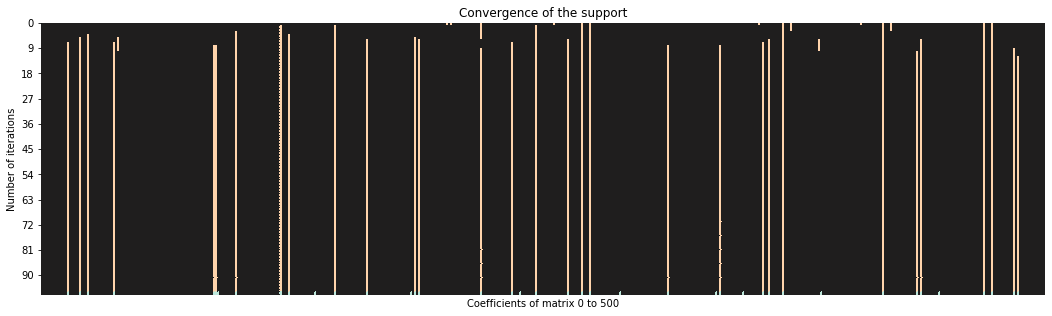

In [27]:
n_iter = len(logging["support"])
plt.figure(figsize=(18,5))
sns.heatmap(np.array(np.append(np.int32(logging["support"]),
                               -np.reshape(adj_matrix.flatten(), (1,n*n)), axis=0)),
           center=0, cbar=False); 
plt.xticks([]); plt.yticks(np.arange(0, n_iter+1, step=n_iter//10), np.arange(0, n_iter+1, step=n_iter//10));
plt.xlim([0, 500])
plt.title("Convergence of the support")
plt.xlabel("Coefficients of matrix 0 to 500");
plt.ylabel("Number of iterations");

Thank you!